In [1]:
import os
import tarfile
from pathlib import Path

def extract_all_images_tar(data_path: str) -> Path:
    data_path = Path(data_path)
    image_path = data_path / "all_images"
    tar_path = data_path / "test_images.tgz"

    # Check if the tar file exists
    if not tar_path.exists():
        print(f"Error: The tar file {tar_path} does not exist.")
        return image_path  # return the expected path

    # Check if the target directory already exists
    if image_path.exists():
        print(f"The directory {image_path} already exists. Skipping extraction.")
        return image_path

    try:
        # Extract the tar file into the data_path
        with tarfile.open(tar_path, "r:gz") as tf:
            print(f"Extracting {tar_path} into {data_path}")
            tf.extractall(path=data_path, filter=lambda tarinfo, _: tarinfo) #to avoid deprecation warning 

        # Rename the extracted 'test_images' directory to 'all_images'to avoid confusion
        extracted_dir = data_path / "test_images"
        if extracted_dir.exists():
            extracted_dir.rename(image_path)
            print(f"Renamed '{extracted_dir}' to '{image_path}'")
        else:
            image_path.mkdir(parents=True, exist_ok=True)

    except Exception as e:
        print(f"An error occurred during extraction: {e}")
        return image_path  # Return the path even if creation failed

    # Remove the tar file
    tar_path.unlink()

    return image_path


In [2]:
data_path = "/Users/abrahamchandy/Documents/Work/Self/ProjectYear/2025/imageClassifier/data"
image_path = extract_all_images_tar(data_path)

Error: The tar file /Users/abrahamchandy/Documents/Work/Self/ProjectYear/2025/imageClassifier/data/test_images.tgz does not exist.


In [3]:
type(image_path)

pathlib.PosixPath

In [4]:
image_path

PosixPath('/Users/abrahamchandy/Documents/Work/Self/ProjectYear/2025/imageClassifier/data/all_images')

In [5]:
images = []
for x in image_path.iterdir():
    images.append(x)
len(images)

2

In [6]:
first_image = images[0]
file_name = first_image.name

In [7]:
file_name.startswith("ticker")

False

In [8]:
import math
from pathlib import Path
import shutil
from typing import Tuple, List

def separate_images_by_class(root: str, train_ratio: float=0.75)-> Tuple[Path, Path]:
    """
    Separate images into two classes - one that has tickers and another that does not
    Since we will be working with a training and a validation dataset, we will split 
    the data into the following subdirectories. An unseen test dataset will be provided.

    Splitting into directories is a good idea since PyTorch's ImageFolder works on folders
    containing classes. We split the data into:
        - train/ticker
        - train/no_ticker
        - val/ticker
        - val/no_ticker

    Args: 
        root (str): The path to the folder containing all images
        train_ratio: Proportion of images to use in the training (remaining is for validation)

    Returns: 
        Tuple[Path, Path]: A tuple containing the paths to the training and validation directories.
    """
    root = Path(root)
    tickers = [
        file for file in root.iterdir()
        if file.is_file() and file.name.startswith("ticker")
    ]
    no_tickers = [
        file for file in root.iterdir()
        if file.is_file() and file.name.startswith("no_ticker")
    ]

    print(f"Number of images with tickers: {len(tickers)}")
    print(f"Number of images without tickers: {len(no_tickers)}")
    
    # split the ticker class
    ticker_train_count = math.floor(train_ratio*len(tickers))
    train_tickers = tickers[:ticker_train_count]
    val_tickers = tickers[ticker_train_count:]

    # split the no_ticker class
    no_ticker_train_count = math.floor(train_ratio*len(no_tickers))
    train_no_tickers = no_tickers[:no_ticker_train_count]
    val_no_tickers = no_tickers[no_ticker_train_count:]

    # create train and validation directories for each class
    train_dir = root / "train"
    val_dir = root / "val"
    
    # create subdirectories per class for train_dir
    train_ticker_dir = train_dir / "ticker"
    train_no_ticker_dir = train_dir / "no_ticker"

    # create subdirectories per class for the val_dir
    val_ticker_dir = val_dir / "ticker"
    val_no_ticker_dir = val_dir / "no_ticker"

    # Create all the subdirectories with `.mkdir()`
    for dir_ in [
        train_ticker_dir, train_no_ticker_dir, val_ticker_dir, val_no_ticker_dir
    ]:
        dir_.mkdir(parents=True, exist_ok=True)

    # move files into the correct subdirectory
    move_files(train_tickers, train_ticker_dir)
    move_files(val_tickers, val_ticker_dir)
    move_files(train_no_tickers, train_no_ticker_dir)
    move_files(val_no_tickers, val_no_ticker_dir)
    
    return train_dir, val_dir
    
def move_files(file_paths: List[Path], destination_folder: Path):
    """
    Moves each file in file_paths into a directory
    """
    
    for file in file_paths:
        target = destination_folder / file.name
        shutil.move(str(file), str(target))


In [9]:
train_dir, val_dir = separate_images_by_class(image_path)

Number of images with tickers: 0
Number of images without tickers: 0


In [10]:
from torchvision import datasets, transforms
data_transform = transforms.Compose(
    [
        transforms.Resize(
            size=(64, 64), # change size, add augmentation for other models
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=None
        ),
        transforms.ToTensor()
    ]
)

#### Visualizing a transformed image at random

In [61]:
import random

def plot_transformed_images(image_paths, transform, n=2, seed=42):
    """
    Selects random images from a path of images and loads them, or transforms
    then plots the original verses the transformed version
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)
            # Transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0) #change shape for matplotlib
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

In [62]:
image_paths_list = list(image_path.glob("*/*/*.jpg"))

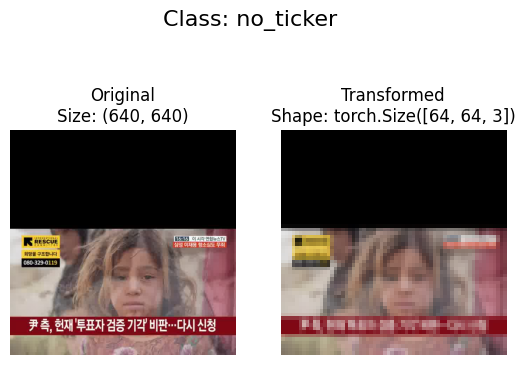

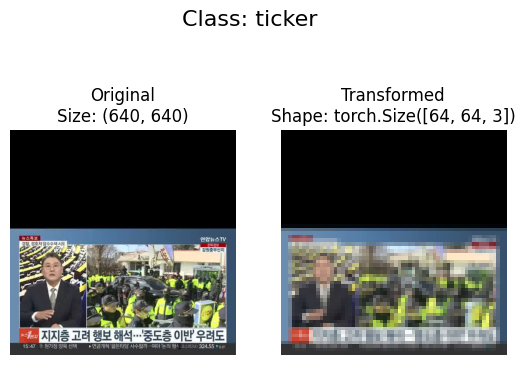

In [63]:
plot_transformed_images(
    image_paths=image_paths_list, transform=data_transform
)

In [11]:
train_data = datasets.ImageFolder(train_dir, transform=data_transform)
train_data.classes

['no_ticker', 'ticker']

In [12]:
for dirpath, dirnames, filenames in os.walk(str(train_dir)):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.')

There are 2 directories and 0 images in /Users/abrahamchandy/Documents/Work/Self/ProjectYear/2025/imageClassifier/data/all_images/train.
There are 0 directories and 558 images in /Users/abrahamchandy/Documents/Work/Self/ProjectYear/2025/imageClassifier/data/all_images/train/ticker.
There are 0 directories and 194 images in /Users/abrahamchandy/Documents/Work/Self/ProjectYear/2025/imageClassifier/data/all_images/train/no_ticker.


In [13]:
for dirpath, dirnames, filenames in os.walk(str(val_dir)):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.')

There are 2 directories and 0 images in /Users/abrahamchandy/Documents/Work/Self/ProjectYear/2025/imageClassifier/data/all_images/val.
There are 0 directories and 186 images in /Users/abrahamchandy/Documents/Work/Self/ProjectYear/2025/imageClassifier/data/all_images/val/ticker.
There are 0 directories and 65 images in /Users/abrahamchandy/Documents/Work/Self/ProjectYear/2025/imageClassifier/data/all_images/val/no_ticker.


In [14]:
### Creating dataloaders
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 16

def create_dataloaders(
    train_dir: str,
    val_dir: str,
    train_transform: transforms.Compose,
    val_transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS 
):
    """Creates training and validation dataloaders.

    Takes in a training directory and validattion directory path and turns them 
    into PyTorch Datasets and then into PyTorch DataLoaders.

    Args:
        train_dir: Path to training directory
        val_dir: Path to validation directory
        transform: torchvision transforms to perform on training and validation data
        batch_size: Number of samples per batch in each of the DataLoaders.
        num_workers: An integer for number of workers per DataLoader.

    Returns:
        A tuple of (train_dataloader, val_dataloader, class_names).
        Where class_names is a list of target classes.
        Example usage:
        train_dataloader, test_dataloader, class_names = create_dataloaders(
            train_dir=path/to/train_dir,
            val_dir=path/to/val_dir,
            batch_size=32,
            num_workers=4
        )
    """
    # create datasets using ImageFolder
    train_data = datasets.ImageFolder(train_dir, transform=train_transform)
    val_data = datasets.ImageFolder(val_dir, transform=val_transform)

    # get class names
    class_names = train_data.classes

    # Make DataLoaders
    train_dataloader = DataLoader(
        train_data, 
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_dataloader = DataLoader(
        val_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    return train_dataloader, val_dataloader, class_names

In [15]:
train_dataloader, val_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    val_dir=val_dir,
    train_transform=data_transform,
    val_transform=data_transform,
    batch_size=BATCH_SIZE # reduce batch size for later models
)

In [16]:
len(val_dataloader)

16

#### Model 1: Tiny VGG

Overview of the model is found here: https://arxiv.org/pdf/2004.15004


 Building this architecture

* There are 2 Blocks.
* Each block has 2 Conv2d layers with 2 ReLU layers and MaxPool2d
* after the 2 blocks, it has the classifier layer

In [17]:
import torch
from torch import nn

class TinyVGG(nn.Module):

    def __init__(
        self, input_shape: int, hidden_units: int, output_shape: int
    )->None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units*13*13,
                out_features=output_shape
            )
        )
    def forward(self, x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))
        

In [18]:
device = "cpu"
model_1 = TinyVGG(
    input_shape=3, 
    hidden_units=10,
    output_shape=len(class_names)
).to(device)

In [19]:
# dummy forward pass
img_batch, label_batch = next(iter(train_dataloader))
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape : {img_single.shape}\n")

#forward pass
model_1.eval()
with torch.inference_mode():
    pred = model_1(img_single.to(device))
print(f"Output Logits: \n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Ouput Prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual Label:\n{label_single}")


Single image shape : torch.Size([1, 3, 64, 64])

Output Logits: 
tensor([[0.0150, 0.0020]])

Output prediction probabilities:
tensor([[0.5033, 0.4967]])

Ouput Prediction label:
tensor([0])

Actual Label:
0


In [20]:
# training and validating the model
from typing import List, Dict, Tuple
import torch
from tqdm.auto import tqdm

def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer:torch.optim.Optimizer,
    device:torch.device
)->Tuple[float, float]:
    """
    Trains a PyTorch model for a single epoch.

    Turns a target Pytorch model to training mode and then runs through all of
    the training steps.

    Args:
        model: A PyTorch model to be trained.
        dataloader: A DataLoader instance for the model to be trained on
        loss_fn: A PyTorch loss function to minimize
        optimizer: a PyTorch optimizer to help minimize the loss function
        device: A target device to compute on

    Returns:
        A tuple of training loss and training accuracy metrics, in the form of 
        (train_loss, train_accuracy). For example: (0.1112, 0.8743)
    """
    model.train()
    train_loss, train_acc = 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

/opt/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
def val_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device
)-> Tuple[float, float]:
    """
    Validates a PyTorch model for a single epoch.

    Turns a target PyTorch model to 'eval' model and then performs
    a forward pass on a testing dataset.

    Args:
        model: A PyTorch model to be tested
        dataloader: A DataLoader instance for the model to be tested on
        loss_fn: A Pytorch loss function to calculate loss on the test data
        device: A target device to compute on 

    Returns:
        a tuple of testing loss and testing accuracy metrics in the form
        (test_loss, test_accuracy). For example: 
        (0.0223, 0.8985)
    """
    model.eval()
    val_loss, val_acc = 0, 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            val_pred = model(X)
            loss = loss_fn(val_pred, y)

            val_loss += loss.item()
            val_pred_class = val_pred.argmax(dim=1)
            val_acc += (val_pred_class == y).sum().item()/len(val_pred_class)
    val_loss /= len(dataloader)
    val_acc /= len(dataloader)
    return val_loss, val_acc    

In [22]:
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device
)-> Dict[str, List[float]]:
    """
    Trains and validates a Pytorch model.

    Passes a target PyTorch model through a train_step() and a test_step()
    function for a number of epochs, training and testing the model in the
    same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
        model: A PyTorch model to be trained and tested.
        train_dataloader: A DataLoader instance for the model to be trained on.
        test_dataloader: A DataLoader instance for the model to be tested on.
        optimizer: A PyTorch optimizer to help minimize the loss function.
        loss_fn: A PyTorch loss function to calculate loss on both datasets.
        epochs: An integer indicating how many epochs to train for.
        device: A target device to compute on

    Returns:
    A dictionary of training and testing loss as well as training and testing accuracy
    metrics. Each metric has a value ina list for each epoch.
    In the form: {
        train_loss: [...],
        train_acc: [...],
        test_loss: [...],
        test_acc: [...]
    }
    For example if training for epochs=2:
        {
            train_loss: [2.0616, 1.0537],
            train_acc: [0,3934, 0.4125],
            test_loss: [1,2537, 1.5706],
            test_acc: [0.3400, 0.2973]
        }
    """
    results = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )
        val_loss, val_acc = val_step(
            model=model,
            dataloader=val_dataloader,
            loss_fn=loss_fn,
            device=device
        )
        print(f"Epoch: {epoch+1}")
        print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
        print(f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}\n")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)
    return results

def test(
    model: torch.nn.Module,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device
)-> Tuple[float, float, List[torch.Tensor], List[torch.Tensor], List[torch.Tensor]]:
    """
    Tests the model on an unseen dataset
    """
    model.eval()
    test_loss, test_acc = 0, 0
    preds, targets, probs = [], [], []

    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            loss = loss_fn(test_pred, y)

            test_loss += loss.item()
            test_pred_class = test_pred.argmax(dim=1)
            test_acc += (test_pred_class == y).sum().item()/len(test_pred_class)

            # store predictions
            preds.append(test_pred_class.cpu())
            targets.append(y.cpu())
            probs.append(torch.softmax(test_pred, dim=1).cpu())
    
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    return test_loss, test_acc, torch.cat(preds), torch.cat(targets), torch.cat(probs)
    
    
    

In [23]:
import torch
from pathlib import Path

def save_model(
    model: torch.nn.Module,
    target_dir: str,
    model_name: str
)->None:
    """Saves a PyTorch model to a target dictionary.

    Args:
        model: A target PyTorch model to save.
        target_dir: A directory for saving the model to.
        model_name: A filename for the saved model. Should include 
        either ".pth" or ".pt" as the file extension.

    Example usage:
        save_model(
            model=model_0,
            target_dir="models",
            model_name="going_modular_tinyvgg_model.pth"
        )
    """
    target_dir = Path(target_dir)
    target_dir.mkdir(parents=True, exist_ok=True)
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), \
    "Model should end with '.pt' or '.pth'"
    model_path = target_dir / model_name
    print(f"Saving model to: {model_path}")
    torch.save(obj=model.state_dict(), f=model_path)

In [25]:
# training script
import os
import torch
from torchvision import transforms
from timeit import default_timer as timer

NUM_EPOCHS = 5
BATCH_SIZE = 16
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001

def train_and_save_params(
    model: torch.nn.Module, 
    model_name: str,
    target_dir: str,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    device: torch.device
)->Dict[str, List[float]]:
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    start_time = timer()
    results = train(
        model=model, 
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        epochs=NUM_EPOCHS,
        device=device
    )
    end_time = timer()
    print(f"Total training time: {end_time-start_time:.3f} seconds")
    save_model(
        model=model,
        target_dir=target_dir,
        model_name=model_name
    )  
    return results

In [32]:
import matplotlib.pyplot as plt

def plot_loss_curves(results: Dict[str, List[float]]):
    "Plots curves of the results dict"
    loss = results['train_loss']
    val_loss = results['val_loss']

    # get accuracy values of the results dict
    accuracy = results['train_acc']
    val_accuracy = results['val_acc']
    epochs = range(len(results['train_loss']))
    plt.figure(figsize=(15, 7))

    #Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    #Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();
    

In [27]:
project_root = Path(data_path).parent
models_dir = project_root/"models"

In [28]:

# model_1
model_1_name = (
    f"tinyvgg_{NUM_EPOCHS}_epochs_{BATCH_SIZE}_batch_size_"
    f"{HIDDEN_UNITS}_hidden_units_{LEARNING_RATE}_lr.pth"
)
model_1_results = train_and_save_params(
    model=model_1, 
    model_name=model_1_name,
    target_dir=models_dir,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device
)


 20%|▏| 1/5 [02:05<08:20, 125.06s/i

Epoch: 1
Train loss: 0.5887 | Train acc: 0.7367
Val loss: 0.5562 | Val acc: 0.7461



 40%|▍| 2/5 [04:09<06:14, 124.91s/i

Epoch: 2
Train loss: 0.5336 | Train acc: 0.7420
Val loss: 0.4680 | Val acc: 0.7461



 60%|▌| 3/5 [06:14<04:09, 124.86s/i

Epoch: 3
Train loss: 0.3258 | Train acc: 0.8112
Val loss: 0.2005 | Val acc: 0.9219



 80%|▊| 4/5 [08:19<02:04, 124.82s/i

Epoch: 4
Train loss: 0.0954 | Train acc: 0.9721
Val loss: 0.0523 | Val acc: 0.9922



100%|█| 5/5 [10:24<00:00, 124.86s/i

Epoch: 5
Train loss: 0.0222 | Train acc: 0.9947
Val loss: 0.0092 | Val acc: 1.0000

Total training time: 624.294 seconds
Saving model to: /Users/abrahamchandy/Documents/Work/Self/ProjectYear/2025/imageClassifier/models/tinyvgg_5_epochs_16_batch_size_10_hidden_units_0.001_lr.pth


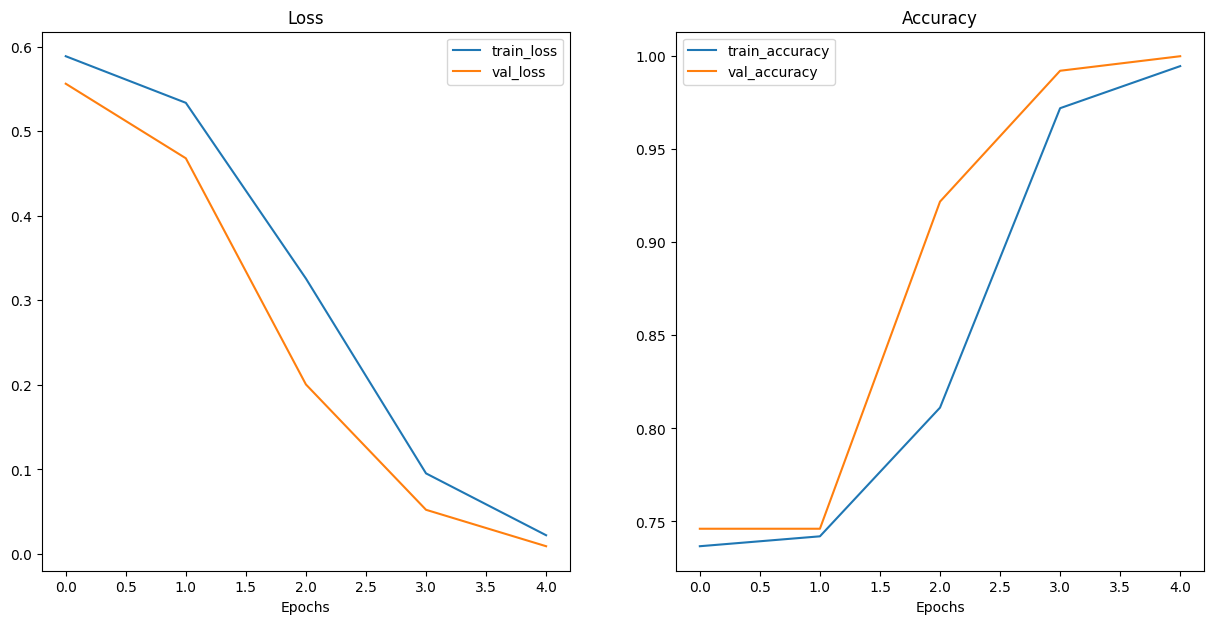

In [33]:
plot_loss_curves(model_1_results)

#### Model 1: Tiny VGG with Data Augmentation

Since the accuracy of the model increases from 74% to over 99.6% in only 5 epochs, it is possible that the model is memorizing patterns in the dataset rather than perdicting them.

Solution: Data Augmentation - Lets implement data augmentation for the training dataset.

In [55]:
train_transform_trivial = transforms.Compose(
    [
        transforms.Resize(size=(64, 64)),
        transforms.TrivialAugmentWide(num_magnitude_bins=31),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)
val_transform_simple = transforms.Compose(
    [
        transforms.Resize(size=(64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

train_aug_dataloader, val_sim_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    val_dir=val_dir,
    train_transform=train_transform_trivial,
    val_transform=val_transform_simple,
    batch_size=BATCH_SIZE # reduce batch size for later models
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1519828].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].


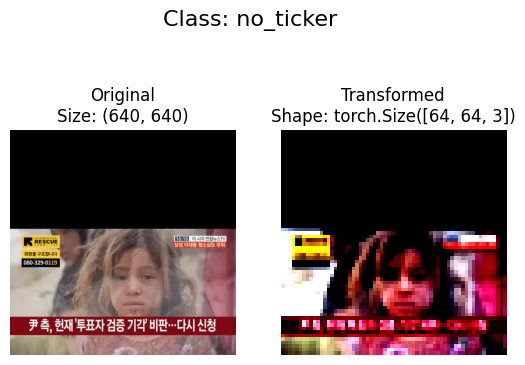

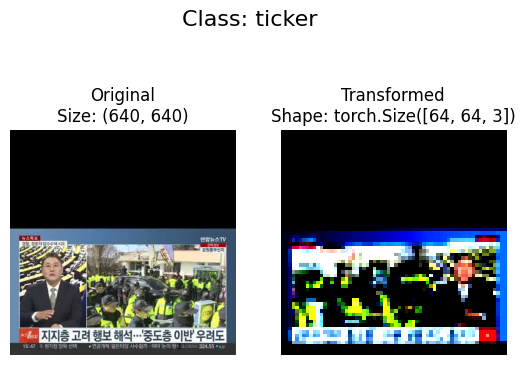

In [64]:
plot_transformed_images(
    image_paths=image_paths_list, transform=train_transform_trivial
)

In [56]:
# model_1_with_data_augmentation
# reinitializing model_1
device = "cpu"
model_1_aug = TinyVGG(
    input_shape=3, 
    hidden_units=10,
    output_shape=len(class_names)
).to(device)

model_1_aug_name = (
    f"tinyvgg_augmented_{NUM_EPOCHS}_epochs_{BATCH_SIZE}_batch_size_"
    f"{HIDDEN_UNITS}_hidden_units_{LEARNING_RATE}_lr.pth"
)
model_1_aug_results = train_and_save_params(
    model=model_1_aug, 
    model_name=model_1_name,
    target_dir=models_dir,
    train_dataloader=train_aug_dataloader,
    val_dataloader=val_sim_dataloader,
    device=device
)


 20%|▏| 1/5 [02:05<08:21, 125.32s/i

Epoch: 1
Train loss: 0.5514 | Train acc: 0.7434
Val loss: 0.4007 | Val acc: 0.7461



 40%|▍| 2/5 [04:10<06:15, 125.19s/i

Epoch: 2
Train loss: 0.3801 | Train acc: 0.8112
Val loss: 0.1258 | Val acc: 0.9648



 60%|▌| 3/5 [06:15<04:10, 125.12s/i

Epoch: 3
Train loss: 0.3124 | Train acc: 0.8617
Val loss: 0.0963 | Val acc: 0.9766



 80%|▊| 4/5 [08:20<02:05, 125.11s/i

Epoch: 4
Train loss: 0.2817 | Train acc: 0.8843
Val loss: 0.0818 | Val acc: 0.9727



100%|█| 5/5 [10:25<00:00, 125.12s/i

Epoch: 5
Train loss: 0.2267 | Train acc: 0.9056
Val loss: 0.1354 | Val acc: 0.9492

Total training time: 625.602 seconds
Saving model to: /Users/abrahamchandy/Documents/Work/Self/ProjectYear/2025/imageClassifier/models/tinyvgg_5_epochs_16_batch_size_10_hidden_units_0.001_lr.pth


#### Plotting loss curves

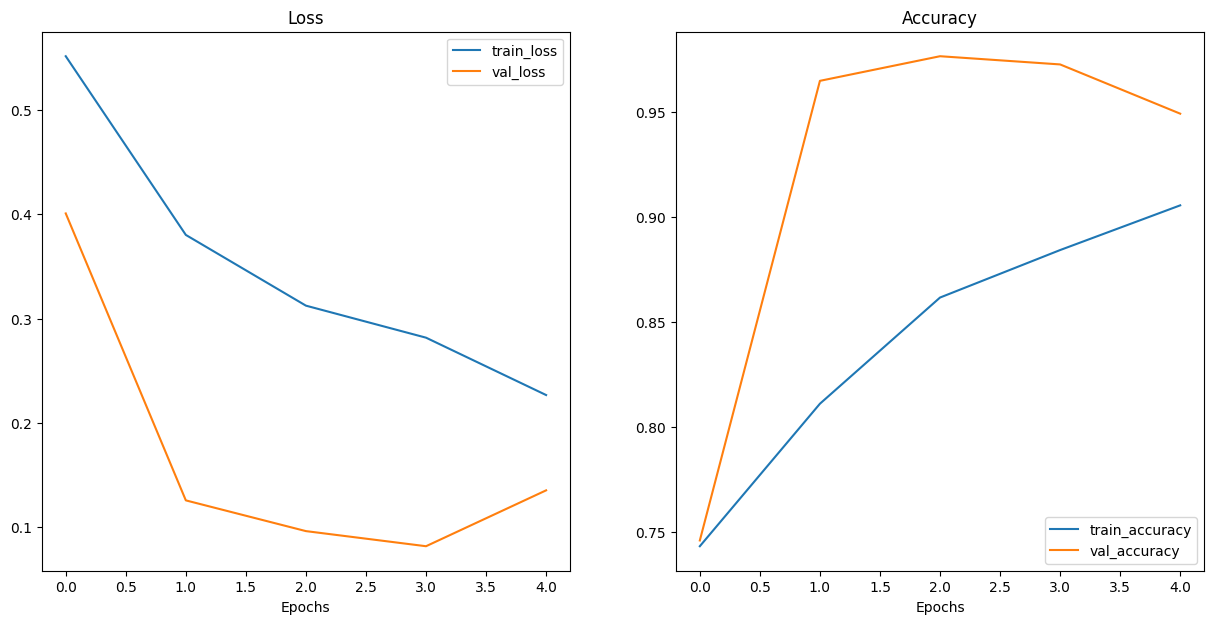

In [65]:
plot_loss_curves(model_1_aug_results)

In [66]:
try:
    import torchinfo
except:
    !pip install torchinfo 
    import torchinfo
from torchinfo import summary
summary(model_1_aug, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 2]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

#### Comparing results with a basic model

In [38]:
class BasicModelV0(nn.Module):
    def __init__(
        self, input_shape: int, hidden_units: int, output_shape: int
    ):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # Flatten inputs into 1D
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x:torch.Tensor):
        return self.layer_stack(x)

In [39]:
model_0 = BasicModelV0(
    input_shape=12288, #output of flatten() layer from the 64* 64*3 pixels
    hidden_units=10,
    output_shape=len(class_names)
)
model_0_name = "linear_with_relu.pth"

model_0_results = train_and_save_params(
    model=model_0, 
    model_name=model_0_name,
    target_dir=models_dir,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device
)

 20%|▏| 1/5 [02:04<08:16, 124.14s/i

Epoch: 1
Train loss: 0.2874 | Train acc: 0.8830
Val loss: 0.1360 | Val acc: 0.9297



 40%|▍| 2/5 [04:08<06:12, 124.14s/i

Epoch: 2
Train loss: 0.0549 | Train acc: 0.9880
Val loss: 0.0449 | Val acc: 0.9922



 60%|▌| 3/5 [06:12<04:08, 124.14s/i

Epoch: 3
Train loss: 0.0222 | Train acc: 0.9960
Val loss: 0.0279 | Val acc: 0.9922



 80%|▊| 4/5 [08:16<02:04, 124.15s/i

Epoch: 4
Train loss: 0.0125 | Train acc: 1.0000
Val loss: 0.0251 | Val acc: 0.9922



100%|█| 5/5 [10:20<00:00, 124.17s/i

Epoch: 5
Train loss: 0.0076 | Train acc: 1.0000
Val loss: 0.0190 | Val acc: 0.9922

Total training time: 620.855 seconds
Saving model to: /Users/abrahamchandy/Documents/Work/Self/ProjectYear/2025/imageClassifier/models/linear_with_relu.pth


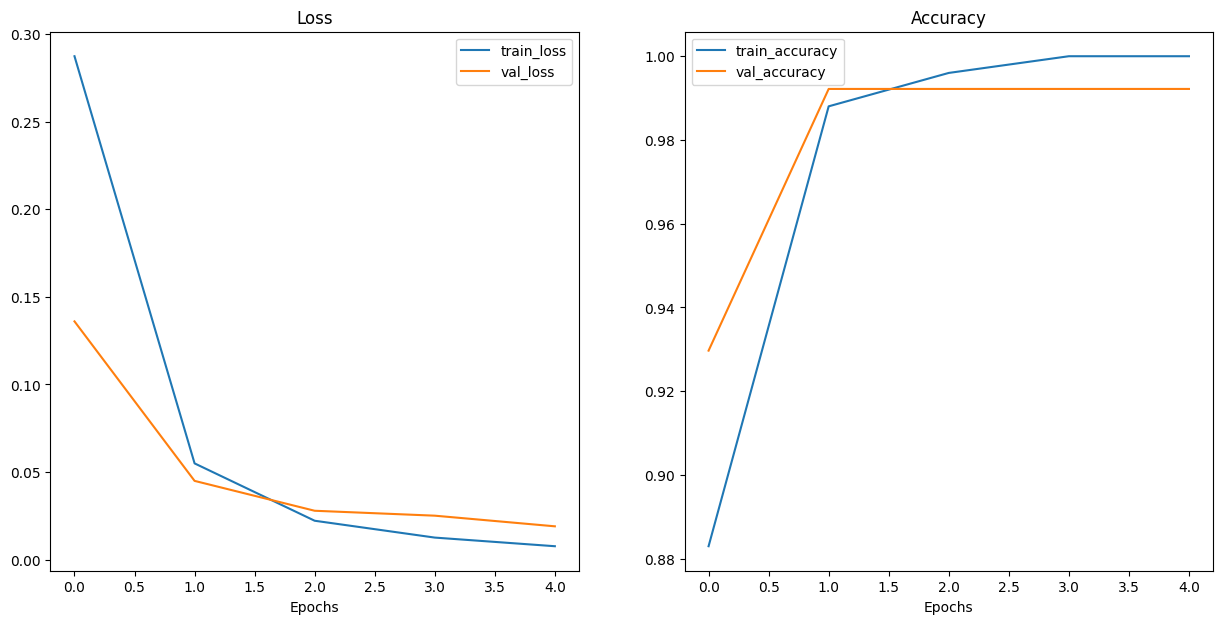

In [40]:
plot_loss_curves(model_0_results)

In [49]:
class CNNWithDropout(nn.Module):
    def __init__(
        self, 
        input_shape: int, 
        hidden_units: int, 
        output_shape: int, 
        dropout: float=0.2
    ):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self._calculate_conv_output(input_shape, hidden_units), output_shape)
        )
    def _calculate_conv_output(self, input_channels, hidden_units):
        dummy_input = torch.randn(1, input_channels, 64, 64)
        dummy_output = self.conv_block(dummy_input)
        return torch.flatten(dummy_output, 1).shape[1]
        
    def forward(self, x):
        return self.classifier(self.conv_block(x))
        

In [50]:
model_0_1 = CNNWithDropout(
    input_shape=3,
    hidden_units=10,
    output_shape=len(class_names)
)
model_0_1_name = "cnn_basic.pth"

model_0_1_results = train_and_save_params(
    model=model_0_1, 
    model_name=model_0_1_name,
    target_dir=models_dir,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device
)

 20%|▏| 1/5 [02:04<08:17, 124.37s/i

Epoch: 1
Train loss: 0.3465 | Train acc: 0.8657
Val loss: 0.0986 | Val acc: 0.9844



 40%|▍| 2/5 [04:08<06:12, 124.28s/i

Epoch: 2
Train loss: 0.0363 | Train acc: 0.9987
Val loss: 0.0193 | Val acc: 1.0000



 60%|▌| 3/5 [06:12<04:08, 124.32s/i

Epoch: 3
Train loss: 0.0100 | Train acc: 1.0000
Val loss: 0.0137 | Val acc: 0.9961



 80%|▊| 4/5 [08:17<02:04, 124.36s/i

Epoch: 4
Train loss: 0.0041 | Train acc: 1.0000
Val loss: 0.0055 | Val acc: 1.0000



100%|█| 5/5 [10:21<00:00, 124.34s/i

Epoch: 5
Train loss: 0.0020 | Train acc: 1.0000
Val loss: 0.0072 | Val acc: 1.0000

Total training time: 621.735 seconds
Saving model to: /Users/abrahamchandy/Documents/Work/Self/ProjectYear/2025/imageClassifier/models/cnn_basic.pth


In [52]:
model_0_1_aug = CNNWithDropout(
    input_shape=3,
    hidden_units=10,
    output_shape=len(class_names)
)
model_0_1_name = "cnn_basic_with_aug.pth"

model_0_1_results = train_and_save_params(
    model=model_0_1_aug, 
    model_name=model_0_1_name,
    target_dir=models_dir,
    train_dataloader=train_aug_dataloader,
    val_dataloader=val_sim_dataloader,
    device=device
)

 20%|▏| 1/5 [02:04<08:17, 124.47s/i

Epoch: 1
Train loss: 0.4396 | Train acc: 0.8298
Val loss: 0.1348 | Val acc: 0.9297



 40%|▍| 2/5 [04:08<06:13, 124.40s/i

Epoch: 2
Train loss: 0.2216 | Train acc: 0.9122
Val loss: 0.0446 | Val acc: 0.9844



 60%|▌| 3/5 [06:13<04:08, 124.44s/i

Epoch: 3
Train loss: 0.1990 | Train acc: 0.9282
Val loss: 0.0607 | Val acc: 0.9727



 80%|▊| 4/5 [08:17<02:04, 124.42s/i

Epoch: 4
Train loss: 0.2001 | Train acc: 0.9189
Val loss: 0.0482 | Val acc: 0.9805



100%|█| 5/5 [10:22<00:00, 124.41s/i

Epoch: 5
Train loss: 0.1549 | Train acc: 0.9415
Val loss: 0.0252 | Val acc: 0.9961

Total training time: 622.036 seconds
Saving model to: /Users/abrahamchandy/Documents/Work/Self/ProjectYear/2025/imageClassifier/models/cnn_basic_with_aug.pth


In [72]:
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from PIL import Image
import torch

def test_model_on_sample_image(
    model: torch.nn.Module, 
    sample_image_path: str, 
    transform: transforms.Compose,
    device: torch.device,
) -> torch.Tensor:
    
    # Load the image and apply transformations
    image = Image.open(sample_image_path)
    image = transform(image)
    
    # add a batch dimension
    image = image.unsqueeze(0)
    
    model.to(device)
    model.eval()
    
    with torch.inference_mode():
    
        prediction = model(image)
        predicted_class = torch.argmax(prediction, dim=1)
            
    return predicted_class

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [73]:
sample = "/Users/abrahamchandy/Documents/Work/Self/ProjectYear/2025/imageClassifier/data/all_images/train/ticker/ticker_00006.jpg"
test_model_on_sample_image(
    model=model_1_aug, 
    sample_image_path=sample, 
    transform=transform,
    device=device
)

tensor([1])

In [74]:
type(class_names)

list

In [76]:
class_names[torch.tensor([1])]

'ticker'